In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools as it
import math as math
%matplotlib inline

In [13]:
def create_vandermonde(x, m):
    Ai=np.tile(x,(m+1,1)).T
    Aj=np.arange(0,m+1)
    A=np.power(Ai,Aj)
    return A

x = np.arange(1, 10)
create_vandermonde(x, 3)


array([[  1,   1,   1,   1],
       [  1,   2,   4,   8],
       [  1,   3,   9,  27],
       [  1,   4,  16,  64],
       [  1,   5,  25, 125],
       [  1,   6,  36, 216],
       [  1,   7,  49, 343],
       [  1,   8,  64, 512],
       [  1,   9,  81, 729]])

In [14]:
def solve_linear_LS(A, y):
    z_hat=np.linalg.lstsq(A, y, rcond=None)[0]
    return z_hat

best polynomial fit is 0.2321 x^2 + 0.6893 x^1 + 0.9000
minimum squared error is 0.1821


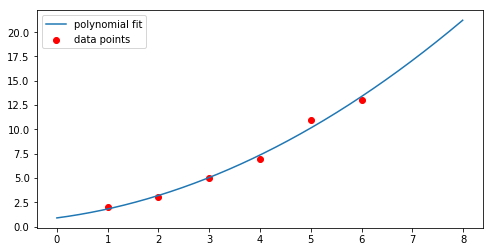

In [15]:
x = np.array([1, 2, 3, 4, 5, 6])
y = np.array([2, 3, 5, 7, 11, 13])
m = 2
A=create_vandermonde(x, m)
z_hat=solve_linear_LS(A,y)
mse=np.square(y-np.dot(A,z_hat)).mean()
xx=np.arange(0,8,0.01)
xx=np.arange(0,8,0.01)
yy=0
for i in range(len(z_hat)):
     yy=yy+z_hat[i]*np.power(xx,i)
plt.figure(figsize=(8, 4))
plt.scatter(x, y, color='red', label='data points')
plt.plot(xx, yy, label='polynomial fit')
plt.legend()
poly_expr = ' + '.join(['{0:.4f} x^{1}'.format(v, i) for i, v in enumerate(z_hat) ] [::-1])[:-4]
print('best polynomial fit is {0}'.format(poly_expr))
print('minimum squared error is {0:.4f}'.format(mse))


In [16]:
df = pd.read_csv('mnist_train.csv')
# Merge pixels into feature column and keep only feature and label
df['feature'] = df.apply(lambda row: row.values[1:] , axis=1)
df = df[['feature', 'label']]


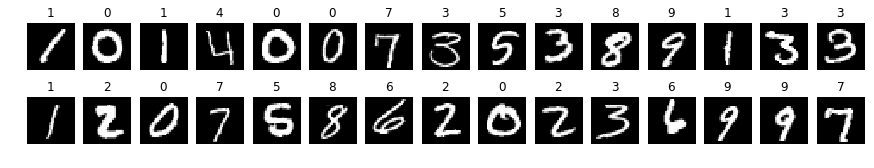

In [17]:
 # Plot MNIST
plt.figure(figsize=(15, 2.5))
for i, row in df.iloc[:30].iterrows():
    x, y = row['feature'], row['label']
    plt.subplot(2, 15, i + 1)
    plt.imshow(x.reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title(y)


In [18]:
def extract_and_split(df, d, test_size=0.5):
  
    #extract target"d" and convert label and feature to array
    target= df[df['label'] == d]
    label=np.array(target['label'])
    feature = np.array(target['feature'])
    # split target to two part
    split_size = math.floor(len(label)*test_size)
    random_feature = np.random.permutation(feature)
    y_tr = np.array([d]*split_size).T
    tr_feature = random_feature[:split_size]
    te_feature = random_feature[split_size:]
    y_te = np.array([d]*(len(label)-split_size)).T
    train_feature_arr = np.array(tr_feature)
    test_feature_arr = np.array(te_feature)
    #append -1
    columns_tr = np.array([-1]*len(train_feature_arr)).T
    columns_te = np.array([-1]*len(test_feature_arr)).T
    X_tr = np.concatenate(train_feature_arr).reshape(len(train_feature_arr),784)
    X_tr = np.insert(X_tr, 784, values=columns_tr, axis=1)
    X_te = np.concatenate(test_feature_arr).reshape(len(test_feature_arr),784)
    X_te = np.insert(X_te, 784, values=columns_te, axis=1)
    return X_tr, X_te, y_tr, y_te

In [19]:
def remove_outlier(x, thresh=3.5):
    
    if len(x.shape) == 1: x = x[:,None]
    median = np.median(x, axis=0)
    diff = np.sqrt(((x - median)**2).sum(axis=-1))
    modified_z_score = 0.6745 * diff / np.median(diff)
    x_filtered = x[modified_z_score <= thresh]
    return x_filtered

  

Pairwise experiment, mapping 0 to -1, mapping 1 to 1
training error = 0.36%, testing error = 0.79%
Confusion matrix:
 [[2049   17]
 [  18 2324]]


array([0.00362976, 0.00794011])

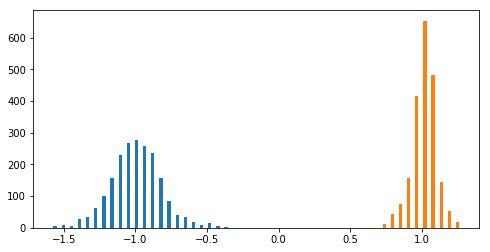

In [27]:
 def mnist_pairwise_LS(df, a, b, test_size=0.5, verbose=False):
    
    # Find all samples labeled with digit a and split into train/test sets\n",
    Xa_tr, Xa_te, ya_tr, ya_te = extract_and_split(df, a, test_size)
   # Find all samples labeled with digit b and split into train/test sets\n",
    Xb_tr, Xb_te, yb_tr, yb_te = extract_and_split(df, b, test_size)
    ya_tr=np.ones((len(ya_tr),), dtype=np.int)*(-1)
    ya_te=np.ones((len(ya_te),), dtype=np.int)*(-1)
    yb_tr=np.ones((len(yb_tr),), dtype=np.int)
    yb_te=np.ones((len(yb_te),), dtype=np.int)
    
    # Construct the full training set\n",
 
    X_tr=np.vstack((Xa_tr,Xb_tr))
    y_tr=np.hstack((ya_tr,yb_tr))
    
    # Construct the full testing set
    X_te = np.vstack((Xa_te,Xb_te))
    y_te = np.hstack((ya_te,yb_te))
     # Run least-square on training set\n",
    z_hat=solve_linear_LS(X_tr, y_tr)
     # Compute estimation and misclassification on training set\n",
    y_hat_tr=np.dot(X_tr, z_hat)
    err_tr=(np.sum(y_hat_tr[0:len(ya_tr)] >0) + np.sum(y_hat_tr[len(ya_tr):]<0))/ len(y_hat_tr)

  # Compute estimation and misclassification on testing set\n",
    y_hat_te=np.dot(X_te, z_hat)
    err_te=(np.sum(y_hat_te[0:len(ya_te)]>0)+np.sum(y_hat_te[len(ya_te):]<0))/len(y_hat_te)
    
    a_a=np.sum(y_hat_te[0 : len(ya_te)] < 0)
    a_b=np.sum(y_hat_te[0 : len(ya_te)] > 0)
    b_a=np.sum(y_hat_te[len(ya_te):]<0)
    b_b=np.sum(y_hat_te[len(ya_te):]>0)

    if verbose:
        print('Pairwise experiment, mapping {0} to -1, mapping {1} to 1'.format(a, b))
        print('training error = {0:.2f}%, testing error = {1:.2f}%'.format(100 * err_tr, 100 * err_te))
        
        # Compute confusion matrix
        cm = np.array([[a_a, a_b], [b_a, b_b] ])
        print('Confusion matrix:\n {0}'.format(cm))

        # Compute the histogram of the function output separately for each class 
        # Then plot the two histograms together
        ya_te_hat, yb_te_hat = np.split(y_hat_te,2)
        output = [remove_outlier(ya_te_hat), remove_outlier(yb_te_hat)]
        plt.figure(figsize=(8, 4))
        plt.hist(output, bins=50)
    
    res = np.array([err_tr, err_te])
    return res
mnist_pairwise_LS(df, 0, 1, verbose=True)

[[0.   0.33 0.78 0.34 0.18 0.76 0.67 0.15 0.69 0.29]
 [0.88 0.   0.92 0.67 0.21 0.55 0.16 0.52 1.65 0.22]
 [1.88 2.65 0.   1.98 0.85 1.25 1.04 1.02 1.96 0.67]
 [1.28 1.52 3.91 0.   0.37 2.68 0.33 0.83 2.67 1.17]
 [0.85 0.81 2.39 1.45 0.   0.63 0.42 0.97 0.43 2.35]
 [2.12 1.61 3.3  5.67 1.85 0.   1.61 0.32 2.51 0.66]
 [1.78 0.95 2.6  1.37 1.34 3.48 0.   0.04 1.01 0.12]
 [0.71 1.48 2.7  2.1  2.28 1.21 0.73 0.   0.59 2.86]
 [1.61 4.17 3.78 4.96 1.49 4.99 2.1  1.79 0.   1.24]
 [1.22 1.1  1.89 2.65 4.9  2.45 0.76 5.19 3.19 0.  ]]


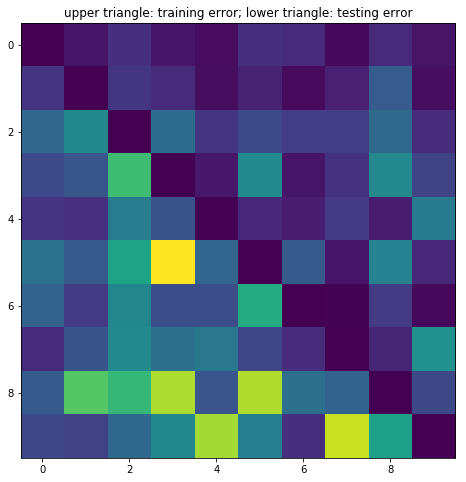

In [29]:
from tqdm import tqdm_notebook as tqdm
num_trial, err_matrix = 1, np.zeros((10, 10))

# Fill the err_matrix, for all a < b
# err_matrix[a, b] = training error between digits a and b
# err_matrix[b, a] = testing error between digits a and b
for b in range(10):
    for a in range(b):
            result = np.zeros((5, 2))
            for i in range(5):
                result[i] = mnist_pairwise_LS(df, a, b, test_size=0.5, verbose=False)
            err_matrix[a, b] = result[:, 0].mean()
            err_matrix[b, a] = result[:, 1].mean()
            

plt.figure(figsize=(8, 8))
plt.imshow(err_matrix)
plt.title('upper triangle: training error; lower triangle: testing error');
print(np.round(err_matrix*100, 2))


In [28]:
def mnist_onehot_LS(df, test_size=0.5):
   
    # Split into training/testing set
    trainingsize = math.floor(len(df)*(1-test_size))
    df_d = df.sample(frac=1)
    tr,te=df_d[:trainingsize], df_d[trainingsize:]
   
     # Construct the training set\n"
    tr_feature=np.array(tr.feature)
    X_tr = np.concatenate(tr_feature).reshape( len(tr_feature), 784)
    columns=np.ones((len(tr_feature),), dtype=np.int)*(-1)
    columns=columns.transpose()
    X_tr = np.insert(X_tr, 784, values=columns, axis=1)
    y_tr=np.array(tr.label)
    
      # Construct the testing set\n"
    te_feature=np.array(te.feature)
    X_te=np.concatenate(te_feature).reshape(len(te_feature), 784)
    columns_te=np.ones((len(te_feature),), dtype=np.int)*(-1)
    columns_te=columns_te.T
    X_te = np.insert(X_te, 784, values=columns_te, axis=1)
    y_te=np.array(te.label)
    
      # Apply one-hot encoding to training labels\n",
    Y_tr=np.zeros((len(tr.label),10))
    Y_te=np.zeros((len(te.label),10))
    for i in range(10):
        Y_tr[tr.label==i, i]=1
        Y_te[te.label==i, i]=1
    Y = np.concatenate((Y_tr,Y_te)).reshape(len(tr)+len(te),10)
    # Run least-square on training set\n",
    Z = solve_linear_LS(X_tr,Y[:len(y_tr)])

    # Compute estimation and misclassification on training set\n",
    y_hat_tr=np.dot(X_tr,Z)
    for i in range(len(y_hat_tr)):
        maxpos=np.argmax(y_hat_tr[i])
        y_hat_tr[i]=0
        y_hat_tr[i][maxpos]=1
    mis=np.absolute(y_hat_tr-Y[:len(y_tr)])
    mis_rowadd=mis.sum(axis=1)
    mis_arr=mis_rowadd[mis_rowadd!=0]
    mistakes=len(mis_arr)
    err_tr=mistakes/len(y_hat_tr)
 
  # Compute estimation and misclassification on training set\n",
    y_hat_te=np.dot(X_te,Z)
    K=Y[len(y_tr):]
    for i in range(len(y_hat_te)):
        max_pose=np.argmax(y_hat_te[i])
        y_hat_te[i]=0
        y_hat_te[i][max_pose]=1
    mis_e=np.absolute(y_hat_te-K)
    mis_rowadd_e=mis_e.sum(axis=1)
    mis_arr_e=mis_rowadd_e[mis_rowadd_e!=0]
    mistakes_e=len(mis_arr_e)
    err_te=mistakes_e/len(y_hat_te)
    # Compute confusion matrix\n",
    for i in range(len(y_hat_te)):
        max_pos_m=np.argmax(y_hat_te[i])
        y_hat_te[i]=0
        y_hat_te[i][max_pos_m]=1
    matrix=np.zeros((10,10))
    for i in range(len(y_hat_te)):
        matrix[K[i]==1,y_hat_te[i]==1]+=1
    cm=np.array(matrix)
        
    print('training error = {0:.2f}%, testing error = {1:.2f}%'.format(100 * err_tr, 100 * err_te))
    print('Confusion matrix:\n {0}'.format(cm))
    return np.array([err_tr, err_te])

mnist_onehot_LS(df)

training error = 13.71%, testing error = 15.05%
Confusion matrix:
 [[1.996e+03 2.000e+00 8.000e+00 9.000e+00 1.200e+01 1.800e+01 2.300e+01
  2.000e+00 1.400e+01 1.000e+00]
 [2.000e+00 2.330e+03 1.100e+01 1.100e+01 7.000e+00 1.000e+01 5.000e+00
  1.000e+00 1.200e+01 2.000e+00]
 [3.200e+01 9.100e+01 1.640e+03 5.000e+01 3.800e+01 5.000e+00 9.000e+01
  3.400e+01 6.000e+01 1.100e+01]
 [1.800e+01 5.900e+01 6.700e+01 1.784e+03 1.100e+01 4.800e+01 1.700e+01
  4.600e+01 5.000e+01 4.900e+01]
 [4.000e+00 3.500e+01 2.400e+01 6.000e+00 1.766e+03 2.900e+01 1.700e+01
  7.000e+00 2.000e+01 1.290e+02]
 [6.600e+01 3.800e+01 1.200e+01 1.840e+02 4.200e+01 1.331e+03 6.800e+01
  1.200e+01 9.500e+01 3.900e+01]
 [4.800e+01 2.200e+01 2.600e+01 1.000e+00 3.400e+01 2.700e+01 1.939e+03
  0.000e+00 9.000e+00 0.000e+00]
 [2.700e+01 6.800e+01 1.600e+01 1.500e+01 6.400e+01 3.000e+00 1.000e+00
  1.862e+03 6.000e+00 1.220e+02]
 [2.000e+01 1.670e+02 1.900e+01 7.600e+01 3.800e+01 8.100e+01 2.000e+01
  7.000e+00 1.562e+03

array([0.13709524, 0.15052381])